[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kyo-takano/efficientcube/blob/main/notebooks/Lights_Out.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/kyo-takano/efficientcube/blob/main/notebooks/Lights_Out.ipynb)

# EfficientCube: 7x7 Lights Out

[![TMLR](https://img.shields.io/badge/TMLR_1188-112467?style=for-the-badge)](https://openreview.net/forum?id=bnBeNFB27b)
[![GitHub Repository](https://img.shields.io/badge/-Repository-2dba4e?logo=github&style=for-the-badge)](https://github.com/kyo-takano/efficientcube)

This notebook is associated with the following publication:
> K. Takano. Self-Supervision is All You Need for Solving Rubik's Cube. Transactions on Machine Learning Research, ISSN 2835-8856, 2023. URL: https://openreview.net/forum?id=bnBeNFB27b.

---

## Overview
This standalone notebook serves as a demonstration of the method proposed in the paper and provides the necessary code to reproduce the experiment. Please refer to the paper for the methodological overview and further details.

## Usage

Following the paper, the number of training steps is set to `10000` and the beam width is set to `1` (equivalent to the greedy search).
If you wish to speed up the training/inference, the mixed precision mode can be enabled by setting `ENABLE_FP16` to `True`.

## Setup

In [ ]:
class TrainConfig:
    max_depth = 49                          # God's Number
    batch_size_per_depth = 1000
    num_steps = 10000
    learning_rate = 1e-3
    INTERVAL_PLOT, INTERVAL_SAVE = 100, 1000
    ENABLE_FP16 = False                     # Set this to True if you want to train the model faster

class SearchConfig:
    beam_width = 1                          # => greedy search
    max_depth = TrainConfig.max_depth * 2   # Any number above God's Number will do
    ENABLE_FP16 = False                     # Set this to True if you want to solve faster

In [ ]:
import os
import time
import random
import pickle
import numpy as np
from copy import deepcopy
from contextlib import nullcontext
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
print(f'os.cpu_count(): {os.cpu_count()}')
!nvidia-smi -L

device: cuda
os.cpu_count(): 2
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-2d030f74-4059-f0d9-b07e-ad81981d48fd)


## Environment
Lights Out 7x7 is a grid puzzle


In [ ]:
class LightsOut7:
    def __init__(self, dim=7):
        self.dtype = np.int64

        # define state and goal
        self.dim = dim
        self.num_tiles = self.dim ** 2
        self.moves = list(range(self.num_tiles))
        self.moves_inference = self.moves
        self.reset()

        # To be consistent with the other environments:
        self.moves_ix_inference = self.moves_inference
        # vectorize the sticker group replacement operations
        self.__vectorize_moves()

    def reset(self):
        self.state = np.zeros((self.num_tiles), dtype=self.dtype)

    def is_solved(self):
        return np.all(self.state == 0)

    def finger(self, move):
        self.state[self.move_matrix[move]] = (self.state[self.move_matrix[move]] + 1) % 2 # Take modulo of odd/even to simulate boolean

    def finger_ix(self, move):
        self.finger(move)

    def apply_scramble(self, scramble):
        if isinstance(scramble, str):
            scramble = scramble.split()
        try:
            scramble = [int(m) for m in scramble]
        except:
            raise TypeError('Scramble sequence to **Lights Out** must be either a list of integers or a *space-delimited* list of integers')

        for m in scramble:
            self.finger(m)

    def scrambler(self, scramble_length=80):
        while True:
            self.reset()
            scramble = []
            moves = list(np.random.permutation(scramble_length))
            for i in range(scramble_length):
                move = moves[i]
                self.finger(move)
                scramble.append(move)

                # yield self.state, move
                yield self.state, scramble

    def __vectorize_moves(self):
        self.move_matrix = np.zeros((self.num_tiles, 5), dtype=np.int64)
        for move in range(self.num_tiles):
            x_pos = int(np.floor(move / self.dim))
            y_pos = move % self.dim

            right = move + self.dim if x_pos < (self.dim-1) else move
            left = move - self.dim if x_pos > 0 else move
            up = move + 1 if y_pos < (self.dim - 1) else move
            down = move - 1 if y_pos > 0 else move

            self.move_matrix[move] = [move, right, left, up, down]

env = LightsOut7()

## Model

In [ ]:
class LinearBlock(nn.Module):
    """
    Linear layer with ReLU and BatchNorm
    """
    def __init__(self, input_prev, embed_dim):
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(input_prev, embed_dim)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(embed_dim)

    def forward(self, inputs):
        x = inputs
        x = self.fc(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

class ResidualBlock(nn.Module):
    """
    Residual block with two linear layers
    """
    def __init__(self, embed_dim):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList([
            LinearBlock(embed_dim, embed_dim),
            LinearBlock(embed_dim, embed_dim)
        ])

    def forward(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        x += inputs # skip-connection
        return x

class Model(nn.Module):
    """
    Fixed architecture following DeepCubeA.
    """
    def __init__(self, input_dim=49, output_dim=49):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.embedding = LinearBlock(input_dim, 5000)
        self.layers = nn.ModuleList([
            LinearBlock(5000,1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000)
        ])
        self.output = nn.Linear(1000, output_dim)

    def forward(self, inputs):
        x = inputs.to(torch.float)
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        logits = self.output(x)
        return logits

model = Model().to(device)

## Training

In [ ]:
class ScrambleGenerator(torch.utils.data.Dataset):
    def __init__(
            self,
            num_workers=os.cpu_count(),
            max_depth=TrainConfig.max_depth,
            total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth
        ):
        self.num_workers = num_workers
        self.max_depth = max_depth
        self.envs = [LightsOut7() for _ in range(num_workers)]
        self.generators = [env.scrambler(self.max_depth) for env in self.envs]

        self.total_samples = total_samples

    def __len__(self):
        return self.total_samples

    def __getitem__(self, i):
        'generate one scramble, consisting of `self.max_depth` data points'
        worker_idx = i % self.num_workers
        X = np.zeros((self.max_depth, 49), dtype=int)
        y = np.zeros((self.max_depth, self.max_depth), dtype=np.float64)
        for j in range(self.max_depth):
            state, scramble = next(self.generators[worker_idx])
            X[j, :] = state
            y[j, scramble] =  1 / self.max_depth
        return X, y

dataloader = torch.utils.data.DataLoader(
    ScrambleGenerator(),
    num_workers=os.cpu_count(),
    batch_size=TrainConfig.batch_size_per_depth
)

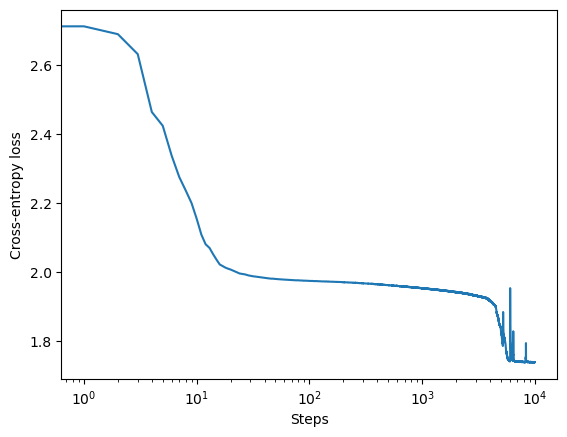

100%|██████████| 10000/10000 [2:16:59<00:00,  1.22it/s]

Model saved.
Trained on data equivalent to 10000000 solves.


In [ ]:
def plot_loss_curve(h):
    fig, ax = plt.subplots(1, 1)
    ax.plot(h)
    ax.set_xlabel("Steps")
    ax.set_ylabel("Cross-entropy loss")
    ax.set_xscale("log")
    plt.show()

def train(model, dataloader):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=TrainConfig.learning_rate)
    g = iter(dataloader)
    h = []
    ctx = torch.cuda.amp.autocast(dtype=torch.float16) if TrainConfig.ENABLE_FP16 else nullcontext()
    for i in trange(1, TrainConfig.num_steps + 1, smoothing=0):
        batch_x, batch_y = next(g)
        batch_x, batch_y = batch_x.reshape(-1, 49).to(device), batch_y.reshape(-1, 49).to(device)

        with ctx:
            pred_y = model(batch_x)
            loss = loss_fn(pred_y, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        h.append(loss.item())
        if TrainConfig.INTERVAL_PLOT and i % TrainConfig.INTERVAL_PLOT == 0:
            clear_output()
            plot_loss_curve(h)
        if TrainConfig.INTERVAL_SAVE and i % TrainConfig.INTERVAL_SAVE == 0:
            torch.save(model.state_dict(), f"{i}steps.pth")
            print("Model saved.")
    print(f"Trained on data equivalent to {TrainConfig.batch_size_per_depth * TrainConfig.num_steps} solves.")
    return model

model = train(model, dataloader)

## Inference

We test and compare on the DeepCubeA dataset

### Dataset: DeepCubeA

Downloading from GitHub

In [ ]:
if "DeepCubeA"!=os.getcwd().split("/")[-1]:
    if not os.path.exists('DeepCubeA'):
        !git clone -q https://github.com/forestagostinelli/DeepCubeA
    %cd ./DeepCubeA/

print('\n### DeepCubeA ###')
filename = 'results/lightsout7/results.pkl'
with open(filename, 'rb') as f:
    result_DeepCubeA = pickle.load(f)

    print(result_DeepCubeA.keys())
    result_DeepCubeA["solution_lengths"] = [len(s) for s in result_DeepCubeA["solutions"]]
    result_DeepCubeA["solution_lengths_count"] = {
        i: result_DeepCubeA["solution_lengths"].count(i)
        for i in range(min(result_DeepCubeA["solution_lengths"]), max(result_DeepCubeA["solution_lengths"]))
    }

    print('No. of cases:', len(result_DeepCubeA["solution_lengths"]))

%cd ../

/DeepCubeA

### DeepCubeA ###
dict_keys(['states', 'solutions', 'paths', 'times', 'num_nodes_generated'])
No. of cases: 500
/


In [ ]:
# Convert optimal solutions to test scrambles
# in LightsOut, applying the solution is equivalent to undoing it.
test_scrambles = result_DeepCubeA["solutions"]
test_scrambles[2]

[29,
 35,
 21,
 28,
 11,
 19,
 6,
 22,
 0,
 24,
 43,
 3,
 18,
 8,
 17,
 20,
 5,
 32,
 47,
 25,
 23,
 40,
 1,
 41,
 39,
 9,
 37,
 33]

### Beam Search

In [ ]:
@torch.no_grad()
def beam_search(
        env,
        model,
        beam_width=SearchConfig.beam_width,
        max_depth=SearchConfig.max_depth,
        skip_redundant_moves=True,
    ):
    """
    Best-first search algorithm.
    Input:
        env: A scrambled instance of the given environment.
        model: PyTorch model used to predict the next move(s).
        beam_width: Number of top solutions to return per depth.
        max_depth: Maximum depth of the search tree.
        skip_redundant_moves: If True, skip redundant moves.
    Output:
        if solved successfully:
            True, {'solutions':solution path, "num_nodes_generated":number of nodes expanded, "times":time taken to solve}
        else:
            False, None
    """
    model.eval()
    with torch.cuda.amp.autocast(dtype=torch.float16) if SearchConfig.ENABLE_FP16 else nullcontext():
        # metrics
        num_nodes_generated, time_0 = 0, time.time()
        candidates = [
            {"state":deepcopy(env.state), "path":[], "value":1.}
        ] # list of dictionaries

        for depth in range(max_depth+1):
            # TWO things at a time for every candidate: 1. check if solved & 2. add to batch_x
            batch_x = np.zeros((len(candidates), env.state.shape[-1]), dtype=np.int64)
            for i,c in enumerate(candidates):
                c_path, env.state = c["path"], c["state"]
                if c_path:
                    env.finger_ix(c_path[-1])
                    num_nodes_generated += 1
                    if env.is_solved():
                        # Revert: array of indices => array of notations
                        c_path = [str(env.moves[i]) for i in c_path]
                        return True, {'solutions':c_path, "num_nodes_generated":num_nodes_generated, "times":time.time()-time_0}
                batch_x[i, :] = env.state

            # after checking the nodes expanded at the deepest
            if depth==max_depth:
                print("Solution not found.")
                return False, None

            # make predictions with the trained DNN
            batch_x = torch.from_numpy(batch_x).to(device)
            batch_p = model(batch_x)
            if beam_width > 1:
                batch_p = torch.nn.functional.softmax(batch_p, dim=-1)
            batch_p = batch_p.detach().cpu().numpy()

            # loop over candidates
            candidates_next_depth = []  # storage for the depth-level candidates storing (path, value, index).
            for i, c in enumerate(candidates):
                c_path = c["path"]
                value_distribution = batch_p[i, :] # output logits for the given state
                if beam_width>1:
                    value_distribution *= c["value"] # multiply the cumulative probability so far of the expanded path

                for m, value in zip(env.moves_ix_inference, value_distribution): # iterate over all possible moves.
                    # predicted value to expand the path with the given move.

                    if c_path and skip_redundant_moves:
                        # logically meaningless operation
                        if m in c_path:
                            continue

                    # add to the next-depth candidates unless 'continue'd.
                    candidates_next_depth.append({
                        'state':deepcopy(c['state']),
                        "path": c_path+[m],
                        "value":value,
                    })

            # sort potential paths by expected values and renew as 'candidates'
            candidates = sorted(candidates_next_depth, key=lambda item: -item['value'])
            # if the number of candidates exceed that of beam width 'beam_width'
            candidates = candidates[:beam_width]


### Solve

In [ ]:
result_ours = {
    "solutions":[],
    "num_nodes_generated":[],
    "times":[]
}
for scramble in tqdm(test_scrambles, position=0):
    # reset and scramble
    env.reset()
    env.apply_scramble(scramble)
    # solve
    success, result = beam_search(env, model)
    if success:
        for k in result_ours.keys():
            result_ours[k].append(result[k])
    else:
        result_ours["solutions"].append(None)

result_ours['solution_lengths'] = [len(e) for e in result_ours['solutions'] if e]
result_ours['solution_lengths_count'] = {
    i: result_ours["solution_lengths"].count(i)
    for i in range(min(result_ours["solution_lengths"]), max(result_ours["solution_lengths"]))
}
f"Successfully solved {len(result_ours['times'])} cases out of {len(result_ours['solutions'])}"

100%|██████████| 500/500 [00:19<00:00, 25.44it/s]


'Successfully solved 500 cases out of 500'

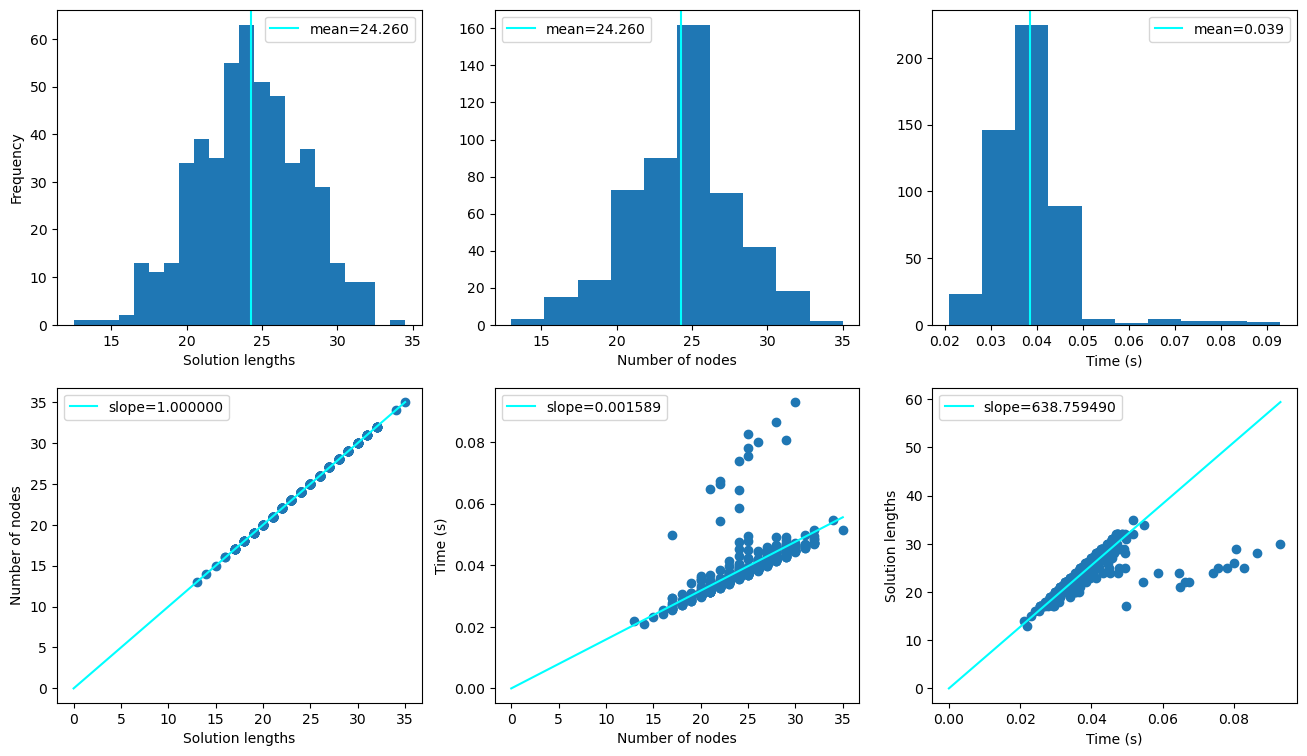

In [ ]:
# Visualize result
fig, ax = plt.subplots(2, 3, figsize=(16, 9))
ax = ax.ravel()
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("Number of nodes")

key_to_text = {
    "solution_lengths":    "Solution lengths",
    'num_nodes_generated': "Number of nodes",
    "times":               "Time (s)",
}

for i, k in enumerate(["solution_lengths", "num_nodes_generated", "times"]):
    v = result_ours[k]
    if k=="solution_lengths":
        v_count = result_ours['solution_lengths_count']
        ax[i].bar(v_count.keys(), v_count.values(), width=1.0)
    else:
        ax[i].hist(v)
    ax[i].axvline(np.mean(v), color="#00ffff", label=f"mean={np.mean(v):.3f}")
    ax[i].set_xlabel(key_to_text[k])
    ax[i].legend()

for i, (key_x, key_y) in enumerate([("solution_lengths", "num_nodes_generated"), ("num_nodes_generated", "times"), ("times", "solution_lengths")]):
    i += 3
    x, y = [result_ours[k] for k in [key_x, key_y]]
    ax[i].set_xlabel(key_to_text[key_x])
    ax[i].set_ylabel(key_to_text[key_y])

    x_range = np.linspace(0, max(x), 100)
    coef = np.mean(np.squeeze(np.array(y) / np.array(x)))
    ax[i].plot(x_range, x_range * coef, label=f"slope={coef:.6f}", color="#00ffff")
    ax[i].scatter(x, y)
    ax[i].legend()

plt.show()

## Comparison to DeepCubeA

### Number of nodes vs. solution length

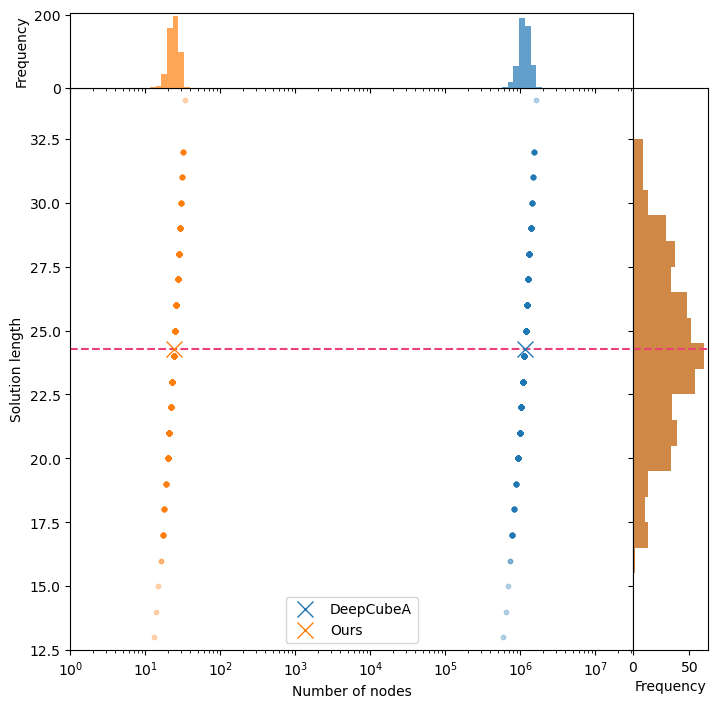

In [ ]:
left, width = 0.12, 0.75
bottom, height = 0.1, 0.75
spacing = 0.0

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height, width, 0.1]
rect_histy = [left + width, bottom, 0.1, height]

fig = plt.figure(figsize=(7.5, 7.5))
ax = fig.add_axes(rect_scatter)
ax.set_xlabel("Number of nodes")
ax.set_ylabel("Solution length")
ax.set_xscale("log")
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
ax_histx.set_ylabel("Frequency")
ax_histy.set_xlabel("Frequency")
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

for AX in [ax, ax_histy]:
    AX.set_ylim(min(result_ours['solution_lengths_count'])-0.5, max(result_ours['solution_lengths_count'])+0.5)

xmin, xmax = 0, 7.5
ax.set_xlim(10**xmin, 10**xmax)
ax_histx.set_xlim(10**xmin, 10**xmax)
bins_x = np.logspace(xmin, xmax, 100)

################################################################################

key_x, key_y = "num_nodes_generated", "solution_lengths"

for k, d in [("DeepCubeA", result_DeepCubeA), ("Ours", result_ours)]:
    x, y = d[key_x], d[key_y]
    ax.scatter(x, y, s=10, alpha=0.3)
    ax_histx.hist(x, bins=bins_x, alpha=0.7)

for i, d in enumerate([result_DeepCubeA, result_ours]):
    d = d["solution_lengths_count"]
    ax_histy.barh(list(d.keys()), list(d.values()), height=1, alpha=0.7)

ax_histy.axhline(np.mean(result_ours[key_y]), ls="--", color="#EB4275")
ax.axhline(np.mean(result_ours[key_y]), ls="--", color="#EB4275")

ax.plot(np.mean(result_DeepCubeA[key_x]), np.mean(result_DeepCubeA[key_y]), "x", markersize=12, label="DeepCubeA")
ax.plot(np.mean(result_ours[key_x]), np.mean(result_ours[key_y]),           "x", markersize=12, label="Ours")
ax.legend()

plt.show()